[<img src="../quantumsymmetry_logo.png" alt="QuantumSymmetry" width="450"/>](https://github.com/dariopicozzi/quantumsymmetry)

> **Note:** if you are running this notebook on Google Colab, the next cell will install quantumsymmetry and its dependencies, as well as the pylatexenc package to enable circuit drawing on Qiskit:

In [62]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip -q install quantumsymmetry
    !pip -q install pylatexenc

# Running a variational algorithm with a symmetry-adapted encoding

The Variational Quantum Eigensolver (VQE) is an algorithm that combines quantum and classical computing to find the lowest energy state of a quantum system, like a molecule. It works by using a quantum computer to create a state with adjustable parameters. These parameters are then optimized by a classical computer to minimize the energy of the system. VQE is particularly useful because it can handle complex quantum systems using today's quantum computers, making it a valuable tool in areas like quantum chemistry and materials science where understanding the ground state energy is essential.

## The unitary coupled clusters (UCC) circuit with a symmetry-adapted encoding

We can then use `quantumsymmetry` to construct a circuit for one of the most common variational circuit choice for the VQE, unitary coupled clusters (UCC).

The UCC circuit prepares a state that approximates:

$$ |\psi_{\text{UCC}}\rangle = e^{\hat{T} - \hat{T}^\dagger} |\psi_{\text{HF}}\rangle$$

where $|\psi_{\text{UCC}}\rangle$ represents the output wavefunction, our guess for the ground state of the molcule. The term $|\psi_{\text{HF}}\rangle$ is the reference wavefunction, the Hartree-Fock state, serving as a starting guess. The operator $\hat{T}$ denotes the excitation operator that accounts for the electron excitations from occupied to unoccupied orbitals.

If we are only including single and double excitations, the operator has the form:

$$ \hat{T} = \hat{T}_1 + \hat{T}_2 $$

Where in terms of creation and annhilation operators (see the previous sections) $\hat{T}_1$ corresponds to single excitations, where an electron is excited from an occupied orbital $i$ to a virtual (unoccupied) orbital $a$:

$$\hat{T}_1 = \sum_{ia} t_i^a \hat{a}_a^\dagger \hat{a}_i $$

And $\hat{T}_2$ corresponds to double excitations, where two electrons are excited simultaneously from occupied orbitals $i$ and $j$ to virtual orbitals $a$ and $b$:

$$\hat{T}_2 = \frac{1}{4} \sum_{ijab} t_{ij}^{ab} \hat{a}_a^\dagger \hat{a}_b^\dagger \hat{a}_j \hat{a}_i$$

In a VQE the parameters within $\hat{T}$ are adjusted to reach the best possible approximation of the true ground state wavefunction.

To increase accuracy, we can also include tripe, quadruple etc excitations. However, if we are looking for the ground state of a molecular system, we do not need to include single excitations, as single excitations do not appear in the ground state wavefunction (this is Brillouin's theorem).

This mirrors the coupled clusters method from traditional computational quantum chemistry: however, because in quantum computing we need the UCC operator is a quantum circuit, it needs to be a unitary operator (quantum circuits need to be unitary operators in order to conserve probabilities: a unitary operator $\hat{U}$ is one that satisfies $\hat{U}^\dagger \hat{U} = \hat{U} \hat{U}^\dagger = \hat{I}$): to ensure this, we take it to approximate $e^{\hat{T} - \hat{T}^\dagger}$ (instead of simply $e^{\hat{T}})$, where $\hat{T}^\dagger$ is its Hermitian conjugate, ensuring that the exponential operator is unitary.

In theory, the UCC circuit is the exponential of a sum of terms. However, in general it is not true that for operators $\hat{A}$ and $\hat{B}$ the exponetial of a sum $e^{\hat{A} + \hat{B}}$ is the same as the product of exponentials $e^{\hat{A}} e^{\hat{B}}$: however, in UCC we make this approximation to be able to break down our circuit into a sequence of exponential circuits (or a more involved one, technically this is known as the Trotter decomposition).

In what follows we look at the exaple of the $H_3^+$ dimer in a STO-3G basis, and run a VQE routine first with the standard Jordan-Wigner encoding, and then with the symmetry-adapted encoding.

In [63]:
from quantumsymmetry import Encoding
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCC, HartreeFock
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

In [64]:
#Parameters for H3+ in the sto-3g basis
atom = 'H 0 0.377 0; H -0.435 -0.377 0; H 0.435 -0.377 0'
charge = 1
spin = 0
basis = 'sto3g'

We first simulate a VQE run under a UCC ansatz with the Jordan-Wigner encoding:

In [65]:
driver = PySCFDriver(
    atom= atom,
    unit=DistanceUnit.ANGSTROM,
    charge=charge,
    spin=spin,
    basis=basis)

problem = driver.run()

mapper = JordanWignerMapper()
initial_state = HartreeFock(
    num_spatial_orbitals = problem.num_spatial_orbitals,
    num_particles = problem.num_particles,
    qubit_mapper = mapper
    )

JW_UCC_ansatz = UCC(
    excitations= 'd',
    num_spatial_orbitals = problem.num_spatial_orbitals,
    num_particles = problem.num_particles,
    qubit_mapper = mapper,
    initial_state = initial_state
    )

vqe = VQE(
    estimator = Estimator(),
    ansatz = JW_UCC_ansatz,
    optimizer = SLSQP()
)

solver = GroundStateEigensolver(mapper, vqe)
vqe_result = solver.solve(problem)

JW_UCC_energy = vqe_result.total_energies[0]
JW_UCC_qubits = JW_UCC_ansatz.num_qubits
JW_UCC_depth = JW_UCC_ansatz.decompose().decompose().decompose().decompose().depth()
JW_UCC_CNOT_count = JW_UCC_ansatz.decompose().decompose().decompose().decompose().count_ops()['cx']
JW_UCC_evals = vqe_result.raw_result.cost_function_evals

If we print out the Jordan-Wigner UCC circuit, we see that this is composed of the Hartree-Fock state preparation followed by a sequence of four exponential circuits, each associated with its own variational parameter:

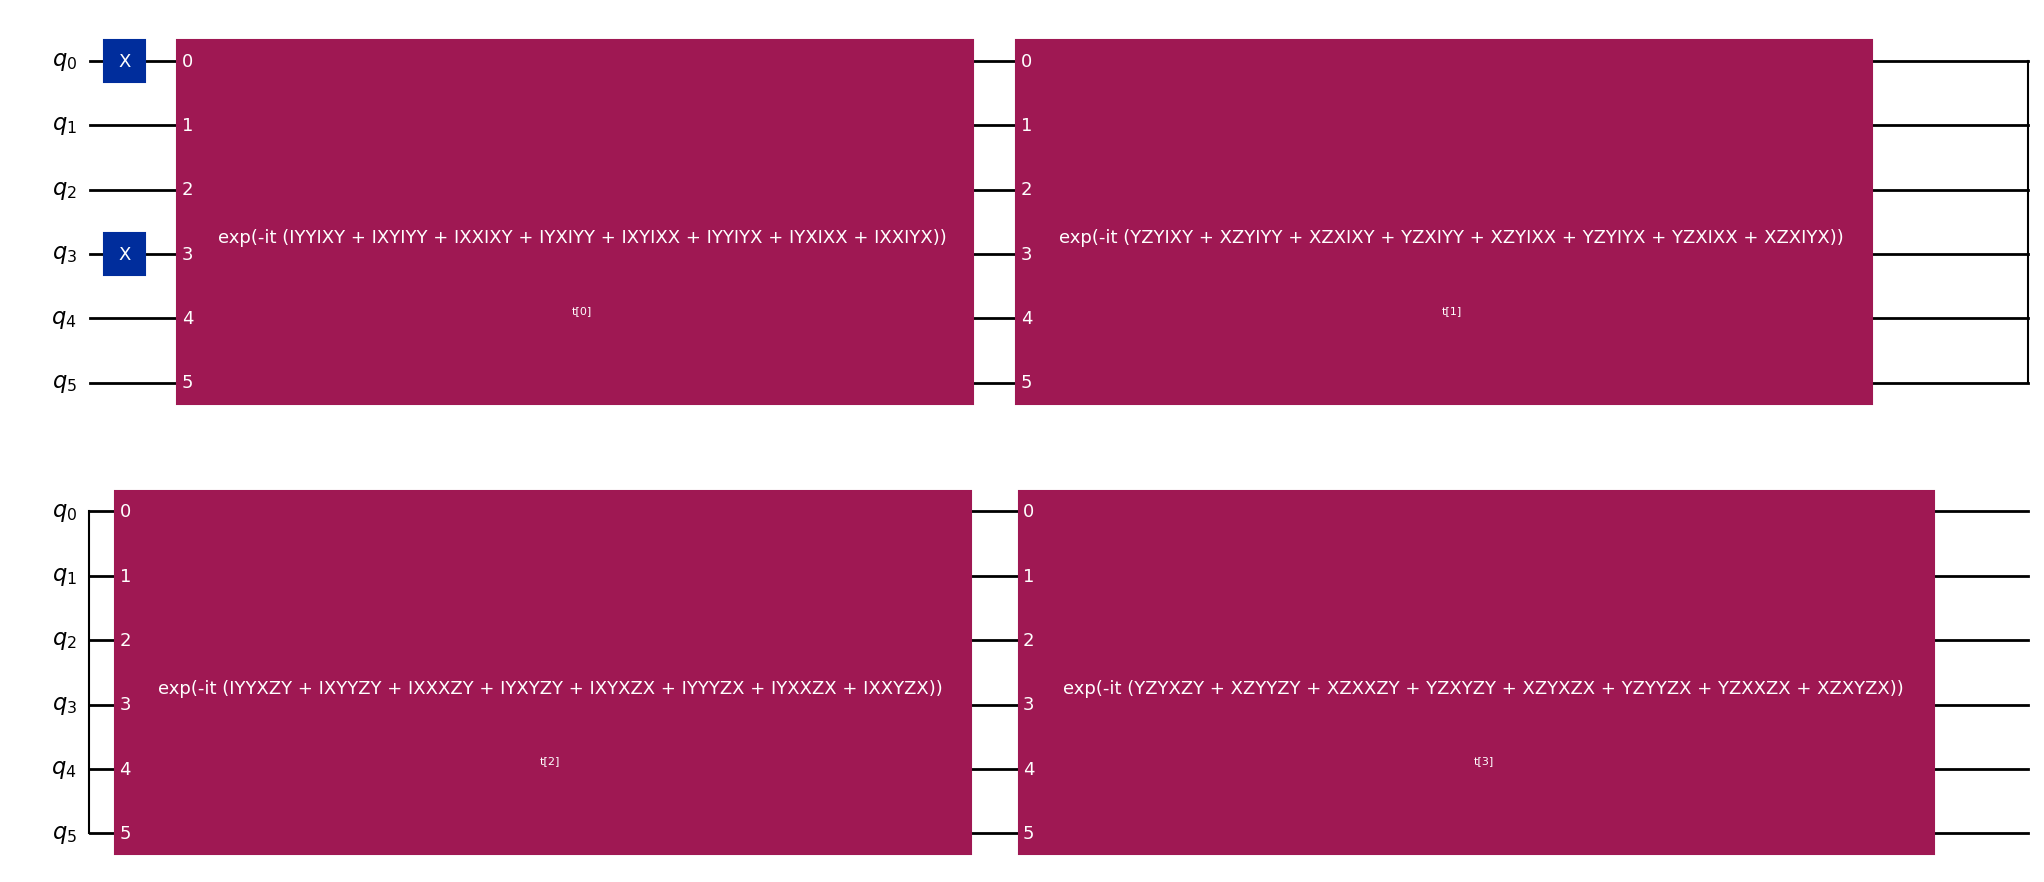

In [66]:
JW_UCC_ansatz.decompose().draw(output='mpl', fold=30)

In [67]:
print(f'The VQE converged to a ground state energy of {JW_UCC_energy} Ha in {JW_UCC_evals} iterations.\nThe circuit depth for the UCC ansatz circuit with the Jordan-Wigner encoding is {JW_UCC_depth} gates on {JW_UCC_qubits} qubits.\nThe number of CNOT gates in the circuit is {JW_UCC_CNOT_count}.')

The VQE converged to a ground state energy of -1.2613448437200259 Ha in 50 iterations.
The circuit depth for the UCC ansatz circuit with the Jordan-Wigner encoding is 388 gates on 6 qubits.
The number of CNOT gates in the circuit is 256.


We then repeat the same VQE UCC simulation using a symmetry-adapted encoding.

In QuantumSymmetrym, we can do this by calling the `.HF_circuit` property to obtain a `QuantumCircuit` object that prepares the Hartree-Fock reference state, and the `.mapper` property of the `Encoding` object to obtain a Qiskit `QubitMapper` object to convert the excitation operators in their symmetry-adapted encoding qubit form:

In [68]:
encoding = Encoding(atom = atom, basis = basis, charge = charge, spin = spin, output_format = 'qiskit')
mapper = encoding.qiskit_mapper
initial_state = encoding.HF_circuit

SAE_UCC_ansatz = UCC(
    excitations= 'd',
    num_spatial_orbitals = problem.num_spatial_orbitals,
    num_particles = problem.num_particles,
    qubit_mapper = mapper,
    initial_state = initial_state
    )

vqe = VQE(
    estimator = Estimator(),
    ansatz = SAE_UCC_ansatz,
    optimizer = SLSQP()
)

solver = GroundStateEigensolver(mapper, vqe)
vqe_result = solver.solve(problem)

SAE_UCC_energy = vqe_result.total_energies[0]
SAE_UCC_qubits = SAE_UCC_ansatz.num_qubits
SAE_UCC_depth = SAE_UCC_ansatz.decompose().decompose().decompose().decompose().depth()
SAE_UCC_CNOT_count = SAE_UCC_ansatz.decompose().decompose().decompose().decompose().count_ops()['cx']
SAE_UCC_evals = vqe_result.raw_result.cost_function_evals

We now print out the symmetry-adapted encoding UCC circuit. In this case the Hartree-Fock state corresponds to the $|000\rangle$ state, and we have just two variational parameters: this is because the remaining two excitations did not commute with the Boolean symmetries, and hence have been discarded, as the symmetry encoding maps them to the zero operator. The resulting circuit is significantly simpler than the one we obtained with the Jordan-Wigner encoding:

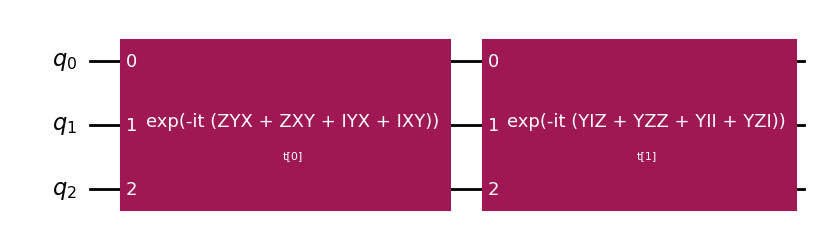

In [69]:
SAE_UCC_ansatz.decompose().draw(output='mpl')

We can further break it down in terms of one-qubit gates and CNOT gates: we obtain a circuit whose depth is significantly smaller than the Jordan-Wigner circuit:

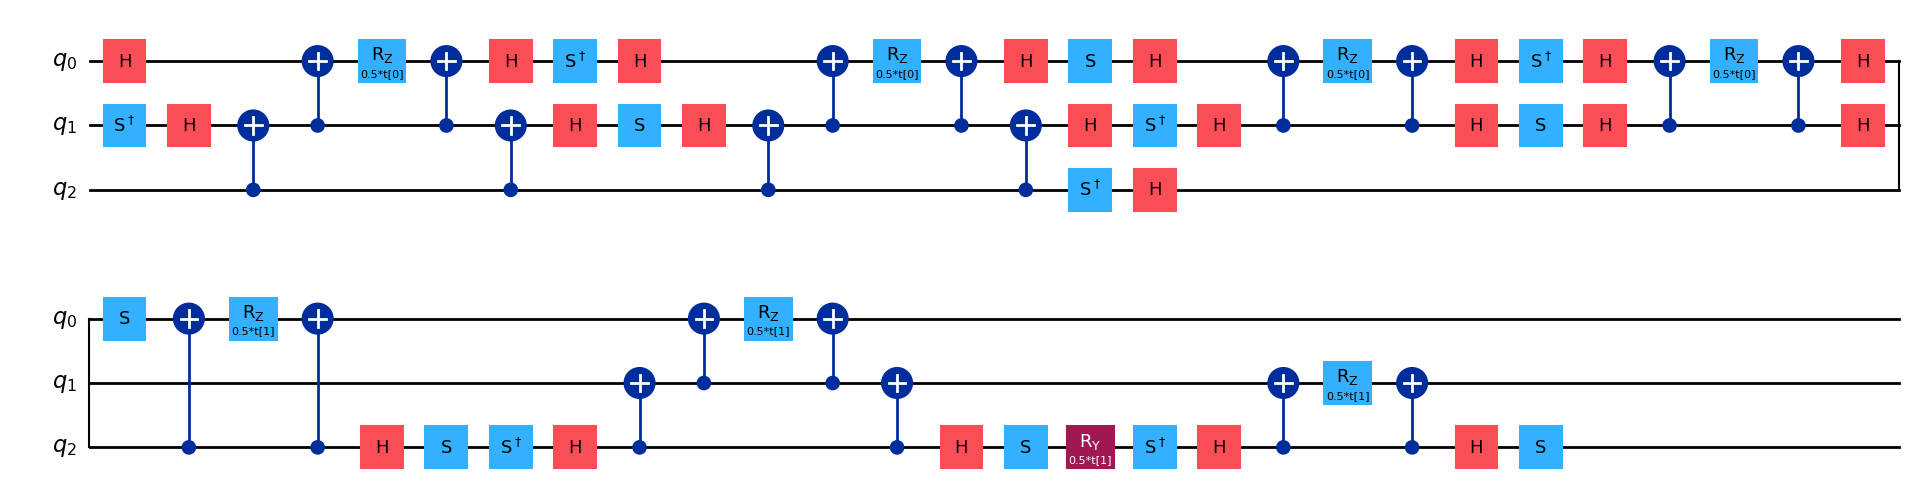

In [70]:
SAE_UCC_ansatz.decompose().decompose().decompose().draw(output='mpl', fold = 28)

In [71]:
print(f'The VQE converged to a ground state energy of {SAE_UCC_energy} Ha in {SAE_UCC_evals} iterations.\nThe circuit depth for the UCC ansatz circuit with the symmetry-adapted encoding is {SAE_UCC_depth} gates on {SAE_UCC_qubits} qubits.\nThe number of CNOT gates in the circuit is {SAE_UCC_CNOT_count}.')

The VQE converged to a ground state energy of -1.2613448697252732 Ha in 17 iterations.
The circuit depth for the UCC ansatz circuit with the symmetry-adapted encoding is 51 gates on 3 qubits.
The number of CNOT gates in the circuit is 20.


In [72]:
print(f'The difference in the ground state energy found with a UCC ansatz using the Jordan-Wigner and the symmetry adapted encoding is {abs(SAE_UCC_energy - JW_UCC_energy)} Ha.')

The difference in the ground state energy found with a UCC ansatz using the Jordan-Wigner and the symmetry adapted encoding is 2.6005247288907185e-08 Ha.


We see that both VQE runs converge to the same energy (up to a small difference in the order of magnitude of $10^{-7}$ Ha). However, by using the symmetry-adapted encoding the number of qubits is reduced from 6 to 3 qubits, and the UCCSD circuit depth is reduced from 414 gates to 80 gates.

## A hardware-efficient full configuration interaction circuit

We see that in this example a two parameter circuit is enough to obtain the UCC wavefunction up to double excitations. However, in this simple case this is actually enough to reach the best wavefunction possible within our choice of basis set: the full-configuration interaction (FCI) wavefunction. We have seen in the circuit diagram above what the symmetry-adapted UCC circuit looks like in terms of one-qubit gates and CNOT gates. Would it be possible to write an equivalent circuit with shorter gate counts?

Let's try and build one:

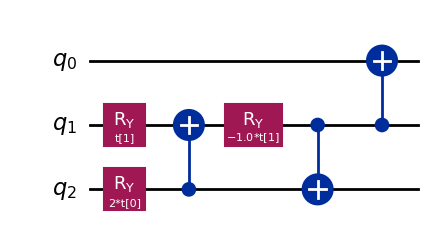

In [73]:
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit.circuit import ParameterVector
t = ParameterVector('t', 2)

SAE_HE_ansatz = QuantumCircuit(3)
SAE_HE_ansatz.ry(2*t[0], 2)
SAE_HE_ansatz.ry(t[1], 1)
SAE_HE_ansatz.cx(2,1)
SAE_HE_ansatz.ry(-t[1], 1)
SAE_HE_ansatz.cx(1,2)
SAE_HE_ansatz.cx(1,0)

SAE_HE_ansatz.draw(output='mpl')

The hardware-efficient circuit prepares a wavefunction of the form:

$$
\begin{aligned}
|\psi (t_0, t_1) \rangle &= \cos{t_0} |000\rangle + \sin{t_0} \cos{t_1} |011\rangle + \sin {t_0} \sin{t_1} |100\rangle\\
&= \cos{t_0} |1σ^2\rangle + \sin{t_0} \cos{t_1} |2σ^2\rangle + \sin{t_0} \sin{t_1} |3σ^2\rangle
\end{aligned}
$$

We can now run VQE again on this circuit:

In [77]:
vqe = VQE(
    estimator = Estimator(),
    ansatz = SAE_HE_ansatz,
    optimizer = SLSQP()
)

solver = GroundStateEigensolver(mapper, vqe)
vqe_result = solver.solve(problem)

SAE_HE_energy = vqe_result.total_energies[0]
SAE_HE_qubits = SAE_HE_ansatz.num_qubits
SAE_HE_depth = SAE_HE_ansatz.decompose().decompose().decompose().decompose().depth()
SAE_HE_CNOT_count = SAE_HE_ansatz.decompose().decompose().decompose().decompose().count_ops()['cx']
SAE_HE_evals = vqe_result.raw_result.cost_function_evals

In [78]:
print(f'The VQE converged to a ground state energy of {SAE_HE_energy} Ha in {SAE_HE_evals} iterations.\nThe circuit depth for the hardware-efficient ansatz circuit with the symmetry-adapted encoding is {SAE_HE_depth} gates on {SAE_HE_qubits} qubits.\nThe number of CNOT gates in the circuit is {SAE_HE_CNOT_count}.')

The VQE converged to a ground state energy of -1.261344867634249 Ha in 13 iterations.
The circuit depth for the hardware-efficient ansatz circuit with the symmetry-adapted encoding is 5 gates on 3 qubits.
The number of CNOT gates in the circuit is 3.


As promised, we obtain an even more compact circuit (just 3 CNOT gates) that converges to the same energy as the previous two! Morevoer, this is the best ground energy estimate that we can obtain for the $H_3^+$ dimer in the STO-3G basis.

## Even more symmetry

In this example the $C_{2v}$ point group is only a proper subgroup (although the largest Boolean subgroup) of $D_{3h}$, the full symmetry group for the trihydrogen cation. With respect to the Boolean symmetry group $C_{2v}$ the $σ’$ and $σ’’$ molecular orbitals are in the $A_1$ and $B_2$ irreducible representations respectively; however, with respect to the full symmetry group $D_{3h}$ they jointly furnish a basis for the two-dimensional irreducible representation $E'$. They therefore have therefore degenerate molecular energies and the requirement that the ground state lies in the totally symmetric representation with respect to $D_{3h}$ (and not just with respect to $C_{2v}$) translates into the the value $t_1 = \frac{π}{4}$, which leaves us with an even simpler one-parameter circuit that prepares the state:

$$
|\psi (t_0) \rangle = \cos{t_0} |1σ^2\rangle + \frac{1}{\sqrt{2}} \sin{t_0} (|2σ^2\rangle + |3σ^2\rangle)
$$

We can run the code above again by setting $t_1 = \frac{π}{4}$ to obtain, again, the same energy:

In [76]:
SAE_HE_ansatz.assign_parameters({t[1]: 0.78539816339}, inplace = True)

<p style="text-align: left"> <a href="04_fermionic_operators.ipynb" />< Previous: Encoding fermionic operators</a> </p>